# EEG Preprocessing - Participant 02
## Song Familiarity study

This notebook demonstrates an EEG preprocessing pipeline applied to the raw data of a single participant from a **song familiarity** experiment. While the same pipeline will be used across all subjects, Participant 02 was selected for demonstration purposes due to the relatively clean quality of their EEG recordings, making it easier to clearly visualize each preprocessing step.

This project reflects the knowledge I gained through my academic background in cognitive neuroscience, supplemented by **independent study and self-directed research**. Although it may not be flawless, it provides a realistic representation of my current capabilities and—more importantly—my ability to **quickly and independently learn and apply new techniques** in EEG data analysis. 

---

### Study Background  
Description from OpenNeuro dataset: This dataset comes from a study involving 29 participants who listened to song melodies and responded as soon as the song felt familiar. Participants were then asked to identify the song by title, artist, or lyrics if possible. Following this, they were shown a multiple-choice display with four song titles, selected one, and received visual feedback indicating whether their choice was correct (green highlight with checkmark) or incorrect (red highlight with an “x”).

---

### Dataset  
The data used in this notebook comes from the publicly available OpenNeuro dataset:  
Jared R. Girard, Aaron M. Bishop, and Cameron D. Hassall (2025). *Song Familiarity*. OpenNeuro.  
[Dataset DOI: 10.18112/openneuro.ds005876.v1.0.1](https://doi.org/10.18112/openneuro.ds005876.v1.0.1)

---

### Contents of this notebook  
- Loading raw EEG data  
- Filtering
- Independent Component Analysis (ICA) for eye-blink and muscle artifact removal
- Epoching around relevant events
- Applying AutoRejection for removal of bad epochs
- Te-referencing
- Baseline correction

---

### Next steps  
This notebook covers only one participant. The full project will include:  
- Scalable preprocessing for all 29 participants
- Feature extraction (e.g., ERP components, spectral power)
- Statistical comparisons based on song recognition accuracy
- Exploratory machine learning: classifying recognition from EEG alone

---

*Created by Andy Hendrikx, 20/05/2025*

*Academic background: RMSc Cognitive Neuroscience*

*This project is part of my self-directed portfolio to demonstrate analysis skills to potential employers.*

## Setup

In [ ]:
# Install the required libraries
%pip install matplotlib
%pip install mne
%pip install mne_bids
%pip install pandas
%pip install autoreject

## Step 1 - Data Import and Setup

This section loads and visualizes the raw EEG data, behavioral responses, and event metadata for Participant 02 from the Song Familiarity dataset. I did this in order to get familiar with the dataset.

For this I use mne-bids provided by: Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: [10.21105/joss.01896](https://doi.org/10.21105/joss.01896)

### Importing Libraries

In this block I import all necessary Python libraries. These libraries cover EEG data handling, visualization, artifact rejection, and data manipulation.

In [1]:
# Import libraries

import matplotlib.pyplot as plt                 # For visualizing plots like EEG signals
from mne_bids import BIDSPath, read_raw_bids    # To access BIDS-formatted EEG data
import mne                                      # Main package for EEG preprocessing and analysis
from mne import Epochs                          # For epoching
import pandas as pd                             # For handling tabular data
import json                                     # For reading additional metadata files
import os                                       # For handling file paths and directories
from autoreject import AutoReject               # For automated bad epoch detection and rejection
import numpy as np                              # For numerical operations

### Loading Raw EEG Data

We define the BIDS path and load the raw EEG data using `read_raw_bids()`. The data is then loaded into memory with `.load_data()`. This step also prints out metadata such as sampling frequency, channel types, and subject info.

In [4]:
# Loading EEG data of the first subject
bids_root = "D:/Data_songfam"
subject = "02"
task = "songfamiliarity"

bids_path = BIDSPath(root=bids_root, subject=subject, task=task, datatype='eeg')
raw = read_raw_bids(bids_path=bids_path, verbose=True)
raw.load_data()
print(raw.info)
print(raw.info.ch_names)

Reading D:\Data_songfam\sub-02\eeg\sub-02_task-songfamiliarity_eeg.fdt
Reading events from D:\Data_songfam\sub-02\eeg\sub-02_task-songfamiliarity_events.tsv.
Reading 0 ... 2036549  =      0.000 ...  2036.549 secs...


C:\Users\anouk\AppData\Local\Temp\ipykernel_11388\525776455.py:7: RuntimeWarning: Did not find any channels.tsv associated with sub-02_task-songfamiliarity.

The search_str was "D:\Data_songfam\sub-02\**\eeg\sub-02*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=True)
C:\Users\anouk\AppData\Local\Temp\ipykernel_11388\525776455.py:7: RuntimeWarning: Unable to map the following column(s) to to MNE:
datetime: 26-Apr-2024 10:02:41
handedness: R
cch: N
  raw = read_raw_bids(bids_path=bids_path, verbose=True)


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FC5, FC1, FCz, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: sub-02, sex: 1>
>
['Fp1', 'F3', 'F7', 'FC5', 'FC1', 'FCz', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'CPz', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AFz', 'Fp2']


#### Note on EOG Channels

While inspecting the channel information in the EEG recording (`raw.info.ch_names`), it appears that **no EOG (electrooculogram) channels** are included in this dataset.

EOG channels are typically used to detect and correct for eye movement and blink artifacts during preprocessing. The absence of these channels means that:
- **Automated artifact rejection methods** (e.g., ICA-based blink detection) may be less effective or require manual adjustment.
- **Alternative strategies** (e.g., visual inspection, component-based manual labeling, or relying on frontal EEG channels like FP1/FP2) may be necessary for identifying ocular artifacts.

This limitation should be taken into account when designing your preprocessing pipeline and interpreting results, especially in frontal EEG analyses.

### Applying Standard Electrode Montage
To ensure accurate spatial interpretation of the EEG signals, a standard electrode montage is applied.

The standard_1020 montage assigns approximate 3D coordinates to the EEG channels based on the international 10-20 system. This step is important for:

- Proper channel visualization (e.g., topographic maps, scalp plots)

- Running spatial filters like ICA

- Aligning EEG data with head models (if used)

Why standard_1020?
This montage was selected based the matching channel names in the dataset. 

In [5]:
raw.set_montage("standard_1020")

<RawEEGLAB | sub-02_task-songfamiliarity_eeg.fdt, 32 x 2036550 (2036.5 s), ~497.2 MiB, data loaded>

### Visualizing Raw EEG Signals

Several plots are created to explore the raw EEG data:
- **Time-domain visualization** of the EEG channels
- **Power spectral density (PSD)** across frequencies
- **Sensor layout**, showing electrode positions
- **Topographical frequency pltos**, giving spatial insight into signal power distribution.

These visualizations help identify signal quality and possible noise/artifacts.

Using matplotlib as 2D backend.


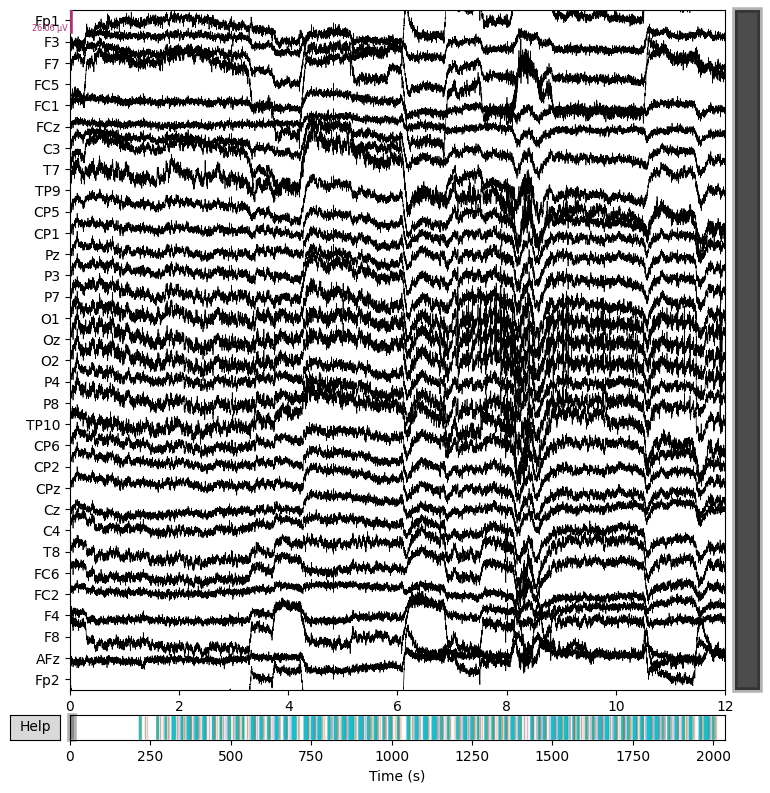

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


c:\Users\anouk\OneDrive\Coding projects\Song familiarity\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


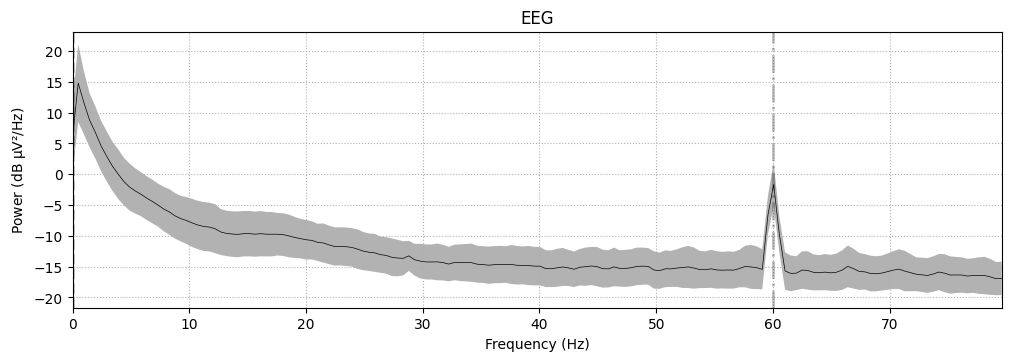

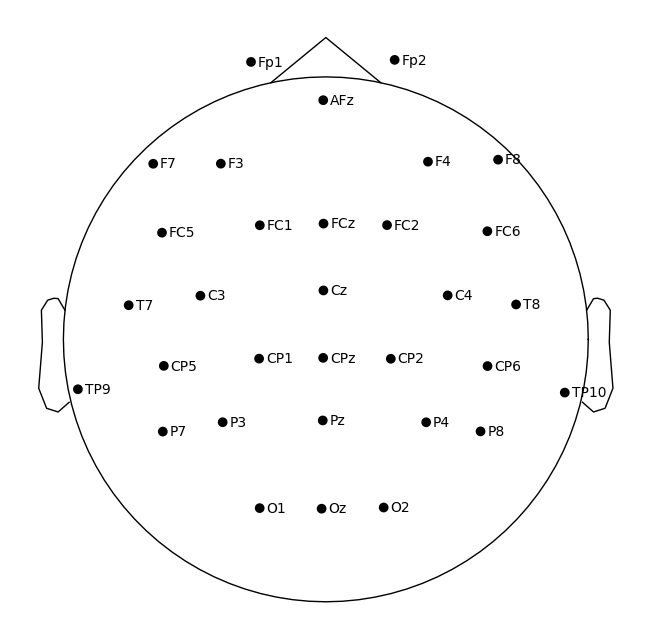

Effective window size : 2.048 (s)


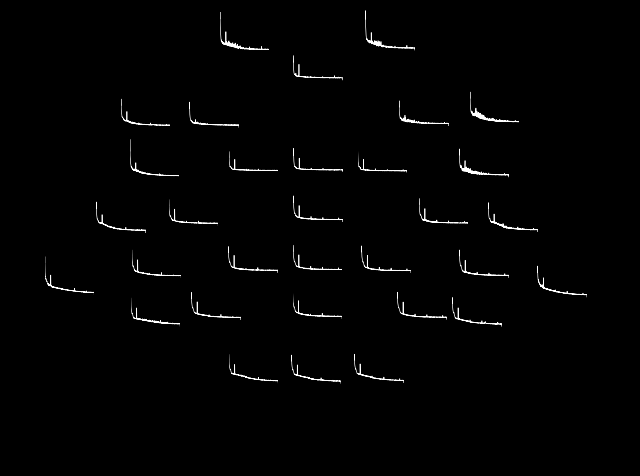

In [6]:
# Explore EEG data
eeg_fig = raw.plot(n_channels=32, duration=12, scalings='auto', clipping=None)
psd_fig = raw.compute_psd(fmax=80).plot(average=True)
electrode_fig = raw.plot_sensors(ch_type='eeg', show_names=True)
psdtopo_fig = raw.compute_psd().plot_topo()

#### What looks good
- **Clear signal quality:** Channels show typical oscillatory EEG patterns with no flatlined or dead channels.
- **Regular event markers:** Vertical bars along the timeline indicate consistent stimulus or response events—likely aligned with song presentations.

#### What needs attention
- **Movement artifacts:** Clear signs of movement artifacts are present, identifiable by the square-shaped wave patterns in the EEG signal.
- **Powerline noise at 60 Hz:** A clear peak in the PSD plot at 60 Hz suggests electromagnetic interference, common in EEG setups.

## Step 2 - Exploring Behavioral and Event Data

We load the behavioral `.tsv` file for participant 02, which includes responses such as:
- Familiarity judgments
- Chosen song titles
- Response times

We also read the associated `.json` file that contains column metadata for interpretation. This gives context to each behavioral variable.

In [7]:
# Loading behavioral data of the first subject
subject_map = f"sub-{subject}"
task = "task-songfamiliarity"
behavior_path = os.path.join(bids_root, subject_map, "beh")
tsv_file = f"sub-{subject}_{task}_beh.tsv"
json_file = f"sub-{subject}_{task}_beh.json"

behavior_df = pd.read_csv(os.path.join(behavior_path, tsv_file), sep="\t")

with open(os.path.join(behavior_path, json_file), 'r') as f:
    meta = json.load(f)

print(behavior_df.head())

   trialNum  songNumber           songFileName    songDur   fixTime  \
0         1          94    rock-a-bye baby.wav  13.924989  0.460674   
1         2          58  itsy bitsy spider.wav   9.802993  0.430153   
2         3          97            rudolph.wav   9.332018  0.467614   
3         4          98      sesame street.wav   9.885986  0.424954   
4         5          28      chicken dance.wav   5.946984  0.426515   

   responded        rt  postMusicTime    reply   promptRT          choicesMC  \
0          1  3.393968       0.495716           14.166283  54   71   27   94   
1          1  2.135457       0.472324      NaN   7.149363  18   29   95   58   
2          1  2.013640       0.402222  rudolph   8.053592  94   80   37   97   
3          0       NaN       0.417355            4.937519  91   98   61   28   
4          1  2.027569       0.457490  chicken   6.369062  31   28   96   12   

   respMC      rtMC  outcomeMC  preFeedbackTime  
0       4  4.782596          1         1.1

### Understanding Event Annotations

Before mapping behavioral events onto the EEG data, it's essential to understand the structure and content of the event annotations. This step loads and explores the timing and labels of events from the accompanying .tsv and .json files.

**Important Note:**

This step is purely exploratory. While we load and inspect event timing here, the actual alignment to EEG data will occur later as I will do resampling on the EEG data, doing it now will cause misalignment.

        onset  duration       sample      value            stim_file
0  215.497000     0.001  215497.0000          1  rock-a-bye baby.wav
1  215.577821     0.000  215577.8209  noteOnset                  NaN
2  215.577821     0.000  215577.8209  noteOnset                  NaN
3  215.863490     0.000  215863.4898  noteOnset                  NaN
4  215.863490     0.000  215863.4898  noteOnset                  NaN
{'x1': 'Start of trial', 'x2': 'Response (spacebar)', 'x3': 'Onset of song identification prompt', 'x4': 'Song identification prompt response (enter key)', 'x5': 'Onset of multiple choice text', 'x6': 'Multiple choice response (1-4)', 'x7': 'Onset of multiple choice outome (correct)', 'x8': 'Onset of multiple choice outcome (incorrect)', 'noteOnset': 'Onset of note'}
{'Start of trial': 1, 'Response (spacebar)': 2, 'Onset of song identification prompt': 3, 'Song identification prompt response (enter key)': 4, 'Onset of multiple choice text': 5, 'Multiple choice response (1-4)': 6,

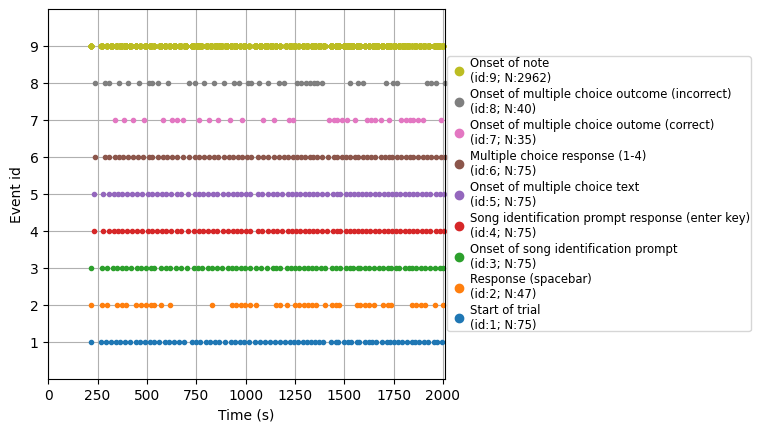

In [8]:
# Define path to the _events.tsv file
events_tsv = os.path.join(bids_root, subject_map, "eeg", f"sub-{subject}_task-songfamiliarity_events.tsv")

# Load the events from the TSV file
events_df = pd.read_csv(events_tsv, sep="\t")

# Check the structure of the events DataFrame
print(events_df.head())

# Load the JSON data on event values
eventjson_path = os.path.join(bids_root, "task-songfamiliarity_events.json")
with open (eventjson_path, 'r') as f:
    events_json = json.load(f)

# Extract the event mapping from the nested structure
event_labels = events_json['type']['Levels']

# Print the event mapping to verify
print(event_labels)

# Clean the mapping by removing the 'x' prefix from the keys
cleaned_keys = {
    k.lstrip('x') if k.startswith('x') else '9': v
    for k, v in event_labels.items()
}
numeric_event_labels = {v: int(k) if k.isdigit() else 9 for k, v in cleaned_keys.items()}

# Print the cleaned mapping to verify
print(numeric_event_labels)

numeric_event_mapping = {"1":1, "2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8, "noteOnset":9}

# Now, map the event values (without 'x') to their corresponding event_id
events_df['event_id'] = events_df['value'].map(numeric_event_mapping)

# Convert the events DataFrame to a numpy array in the format [onset, duration, event_id]
events = events_df[['sample', 'duration', 'event_id']].to_numpy().astype(int)

# Plot the events
events_fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=numeric_event_labels)

## Step 3 - Preprocessing Steps

### Bandpass Filtering
To prepare the EEG data for further analysis, we apply a bandpass filter to remove both slow drifts and high-frequency noise. Based on commonly recommended values for cognitive EEG tasks, the following filter was applied.

This plot helps confirm whether the filtering successfully suppresses unwanted frequencies above 30 Hz, while retaining the relevant neural signal components.

**Note:** These filter settings were selected based on academic knowledge and self-guided research. While they may not be universally optimal, they reflect a solid understanding of EEG preprocessing best practices and show my ability to apply theory to practice.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.3s finished


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


c:\Users\anouk\OneDrive\Coding projects\Song familiarity\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


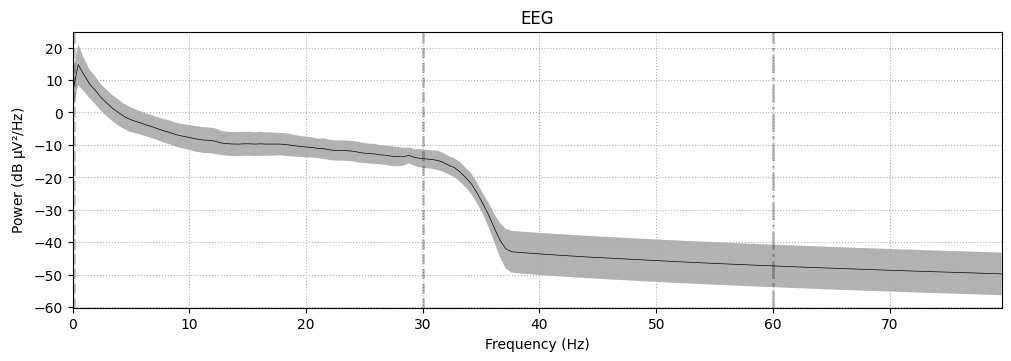

In [9]:
# High/Low-pass filtering
raw = raw.filter(l_freq=0.1, h_freq=30)
psd_fig_posthl = raw.compute_psd(fmax=80).plot(average=True)
display(psd_fig_posthl)

### Downsampling
To reduce computational load and storage requirements, the EEG data was downsampled from its original sampling rate to 256 Hz, a commonly used rate in cognitive neuroscience that still retains sufficient temporal resolution for most ERP analyses.

This resampling step ensures efficient processing for the remainder of the pipeline, especially for tasks like ICA and machine learning applications.

**Note:** The decision to downsample to 256 Hz is based on examples of EEG preprocessing pipelines I came across in my self-guided learning. Professional labs may tweak this value based on their specific hypotheses or hardware.While many studies downsample to around 125–150 Hz, I intentionally chose a slightly higher rate (256 Hz). The reason for this is that my analysis focuses on event-related potentials (ERPs) in response to individual musical notes, particularly to investigate whether the brain responds differently to notes within a melody that is familiar versus unfamiliar.

Maintaining a higher temporal resolution ensures that subtle differences in the timing and shape of ERP components are preserved — which, in my opinion, is crucial for this type of cognitive auditory research.

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


c:\Users\anouk\OneDrive\Coding projects\Song familiarity\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


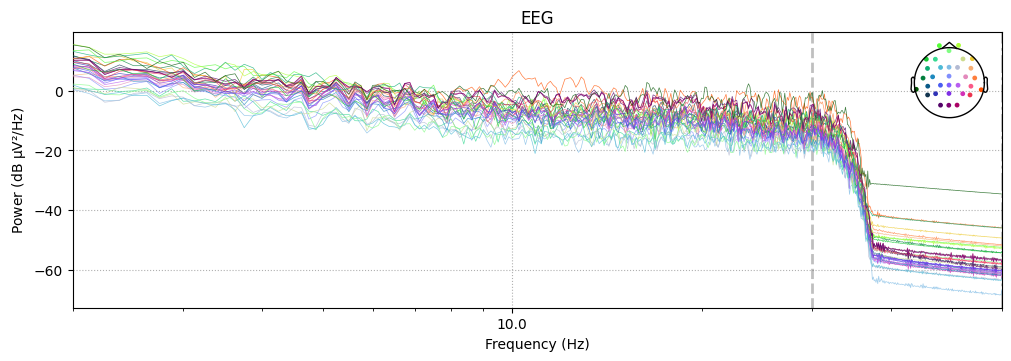

In [10]:
#downsampling
raw.resample(256, npad="auto")
psd_fig_postds = raw.compute_psd(tmin=0, tmax=60, fmin=2, fmax=60).plot(average=False, spatial_colors=True, xscale='log')
display(psd_fig_postds)

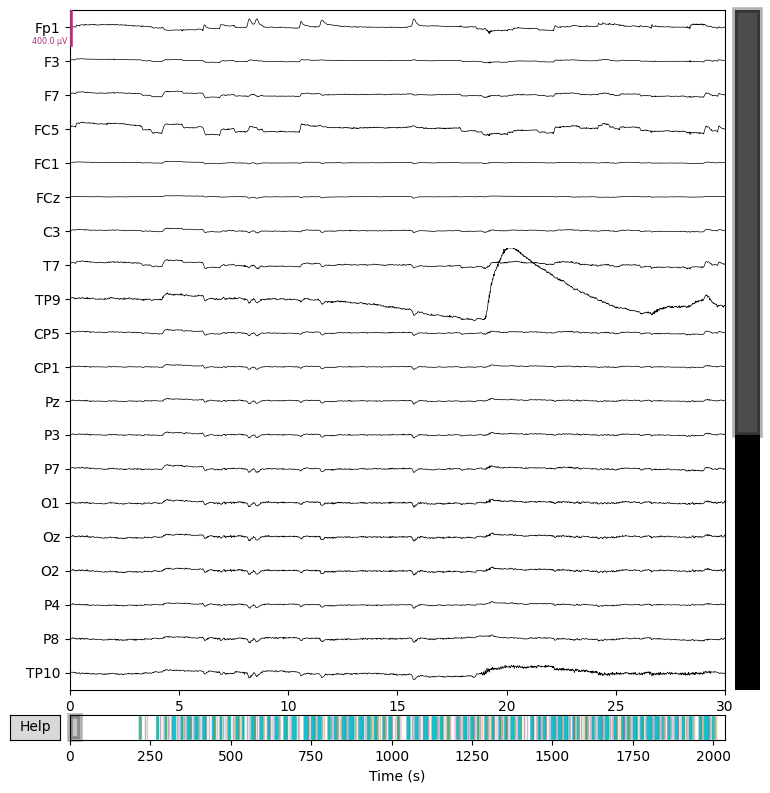

In [12]:
eeg_fig_postfilt = raw.plot(scalings = dict(eeg=200e-6), duration=30);

### Relabeling events
In this step, I implemented a custom labeling function to classify note-onset events (noteOnset, value 9) based on the participant’s subsequent response outcome during the multiple-choice phase.

Specifically, each noteOnset is relabeled depending on whether the first multiple-choice (MC) outcome event that follows it was:

- 7 → Correct → Re-labeled as 100

- 8 → Incorrect → Re-labeled as 101

This approach allows us to isolate event-related brain activity linked specifically to “correct” vs. “incorrect” recognitions — essential for probing familiarity-related ERP differences.

In [13]:
events, event_id = mne.events_from_annotations(raw)


def label_note_epochs_full(events):
    labeled_events = []
    i = 0
    while i < len(events):
        event = events[i]
        if event[2] == 9:  # noteOnset: replace with 100 or 101 based on next MC outcome
            note_onset_sample = event[0]
            # Search for next MC outcome
            label = None
            for j in range(i + 1, len(events)):
                outcome_event = events[j]
                if outcome_event[2] in [7, 8]:  # MC outcome
                    label = 100 if outcome_event[2] == 7 else 101
                    break
            if label is not None:
                labeled_events.append([note_onset_sample, 0, label])
            else:
                # No MC outcome found after noteOnset, decide if you want to keep or skip
                # Here, skip this noteOnset event
                pass
        else:
            # Keep other events as they are
            labeled_events.append(event)
        i += 1
    return np.array(labeled_events, dtype=int)


labeled_events = label_note_epochs_full(events)
print(labeled_events)


Used Annotations descriptions: [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('noteOnset')]


[[ 55167      0      1]
 [ 55188      0    101]
 [ 55188      0    101]
 ...
 [513202      0      5]
 [514283      0      6]
 [514582      0      8]]


## Step 4 - Artifact Rejection with ICA
To remove stereotypical artifacts (e.g., eye blinks, lateral eye movements, and muscle noise), I applied Independent Component Analysis (ICA).

### ICA Configuration
This configuration retains 99% of the explained variance from the original signal. The goal here is to preserve as much neural signal as possible while still isolating components representing artifacts.

In [14]:
ica = mne.preprocessing.ICA(n_components=0.99, random_state=97, max_iter='auto')
ica.fit(raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 7.4s.


<ICA | raw data decomposition, method: fastica (fit in 19 iterations on 521357 samples), 11 ICA components (32 PCA components available), channel types: eeg, no sources marked for exclusion>

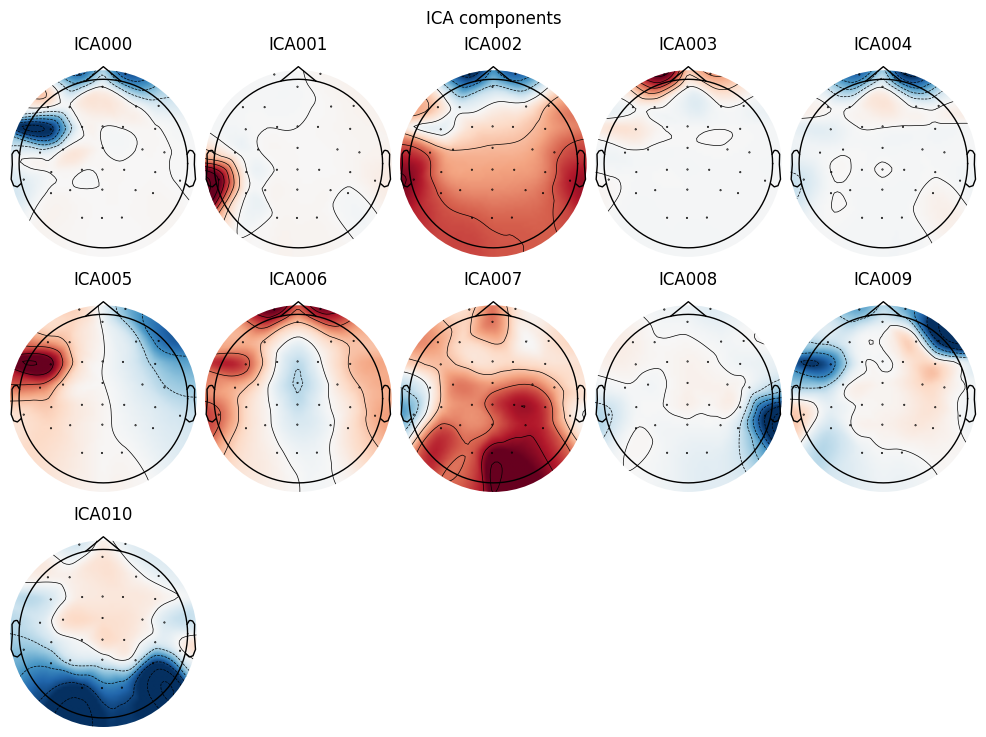

Creating RawArray with float64 data, n_channels=11, n_times=521357
    Range : 0 ... 521356 =      0.000 ...  2036.547 secs
Ready.


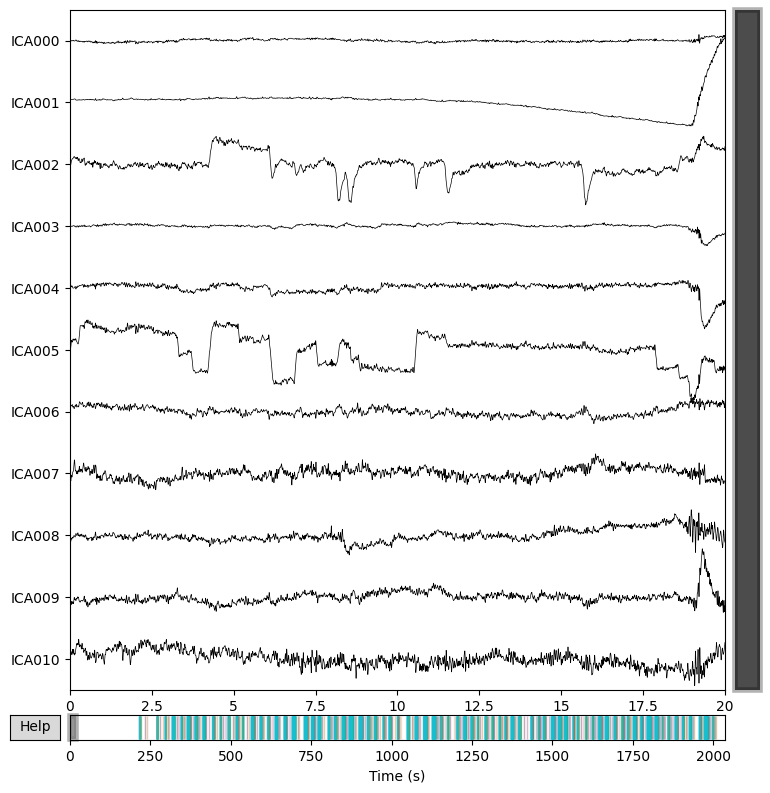

In [15]:
components_plot = ica.plot_components() 
components_time_plot = ica.plot_sources(raw) 

### Detecting Ocular Artifacts

To identify components related to ocular artifacts, I used MNE’s built-in function. I selected Fp1 and Fp2 as the reference channel for EOG detection, since we don't have an EOG channel available and Fp1 and Fp2 is typically close to the eye and is sensitive to eyeblinks.



Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- 

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Identified EOG-related components: []


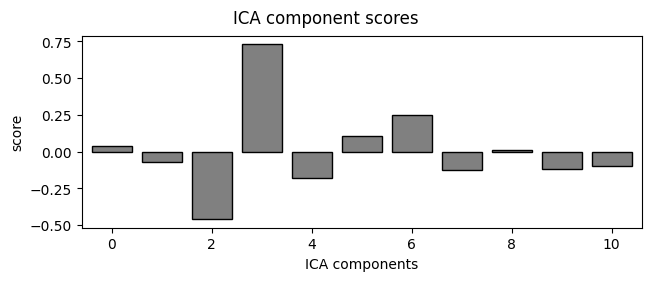

ValueError: No appropriate components found for the given picks ([])

In [16]:
eog_inds, scores = ica.find_bads_eog(raw, ch_name='Fp1')
print(f"Identified EOG-related components: {eog_inds}")

correlation_scores_plot = ica.plot_scores(scores)         
components_corr_plot = ica.plot_components(picks=eog_inds)

Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- 

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Identified EOG-related components: []


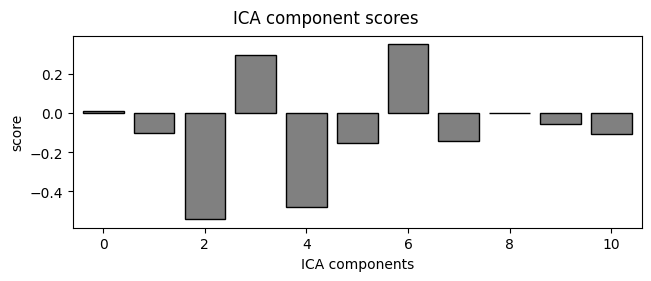

ValueError: No appropriate components found for the given picks ([])

In [17]:
eog_inds, scores = ica.find_bads_eog(raw, ch_name='Fp2')
print(f"Identified EOG-related components: {eog_inds}")

correlation_scores_plot = ica.plot_scores(scores)         
components_corr_plot = ica.plot_components(picks=eog_inds)

While no components were automatically flagged as definitively bad by this function, the correlation scores provide valuable insight into which components may reflect eyeblinks or eye movements.

- This lets me manually keep an eye on suspicious components during visual inspection.

- Since this dataset does not include dedicated EOG channels, this process is based on proximity and assumptions typical of standard EEG setups.

### Detecting Muscle Artifacts
This function is designed to flag ICA components that reflect high-frequency muscle activity, such as jaw tension or facial movement.

📌 Result:
No components were automatically identified as muscle-related artifacts.

- This could be because of the low-pass filter I used

- While this is a good sign for the quality of this particular recording, it doesn't rule out subtle muscle activity. 

In [18]:
ica.find_bads_muscle(raw)

Effective window size : 8.000 (s)


([],
 array([1.05616774e-08, 2.64800951e-07, 2.95680687e-10, 7.50971247e-10,
        2.50719697e-09, 3.50627533e-10, 3.82379832e-09, 1.88806677e-10,
        7.45487372e-10, 7.30382303e-10, 4.56034273e-11]))

### Manual Inspection of ICA Components

While automated tools like find_bads_eog and find_bads_muscle are helpful, manual inspection remains a crucial part of EEG preprocessing.

Each component's time course, power spectrum, and topography were visually assessed to identify:

- Potential eyeblink artifacts

- Muscle activity not caught by automated detection

- Any suspicious or noisy components

This step is especially important when working with real-world data where automatic classification may miss nuanced patterns.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


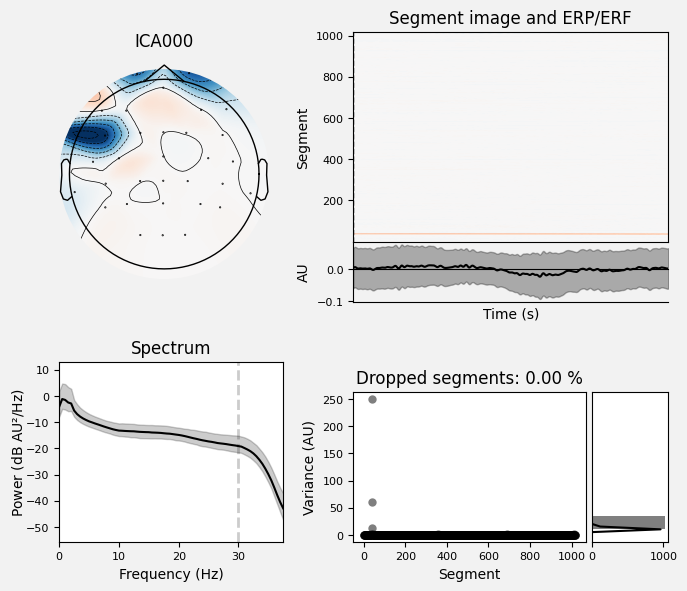

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


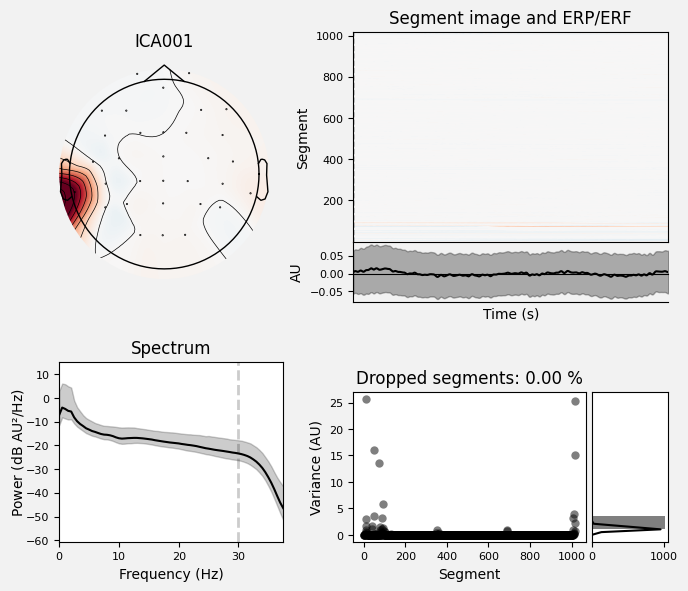

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


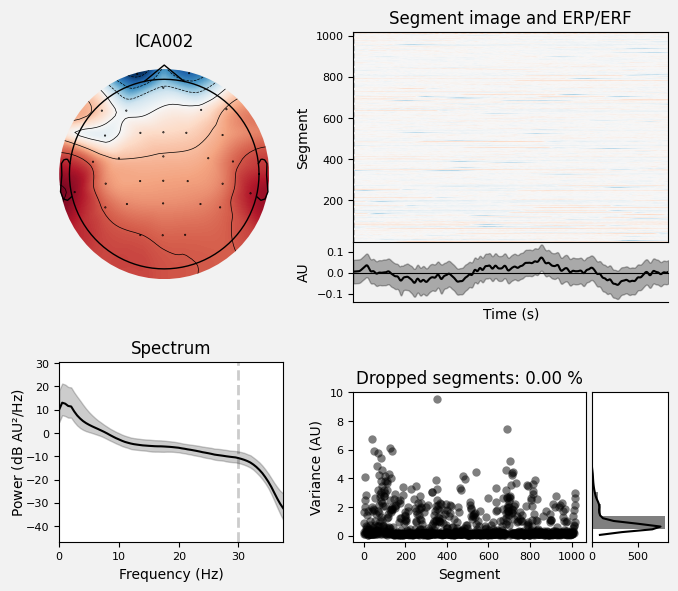

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


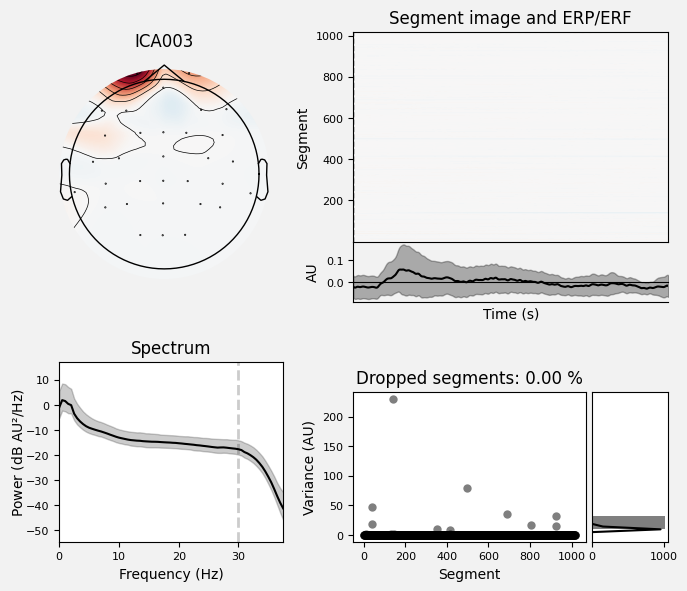

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


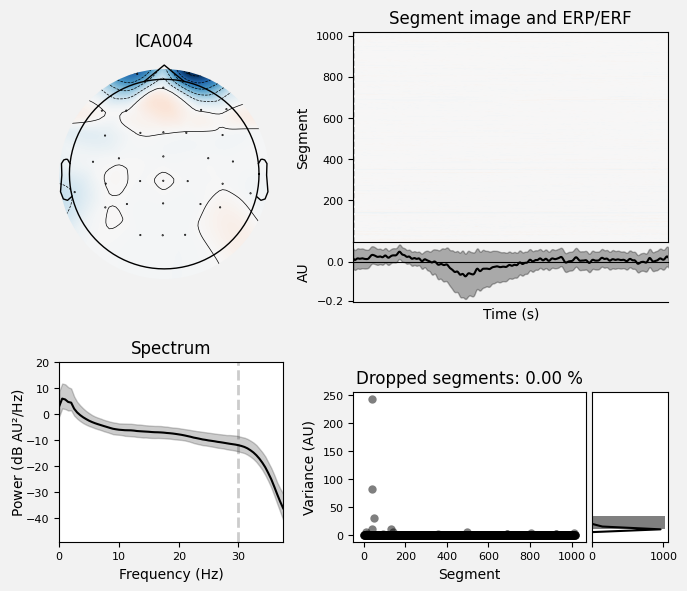

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


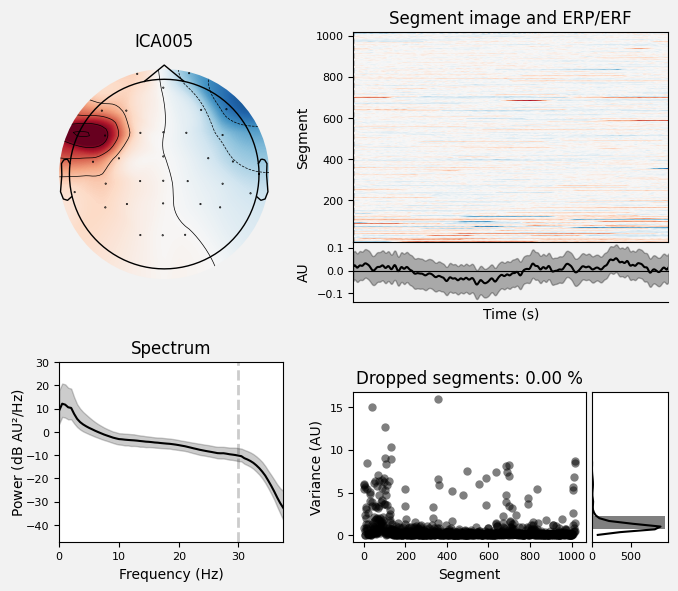

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


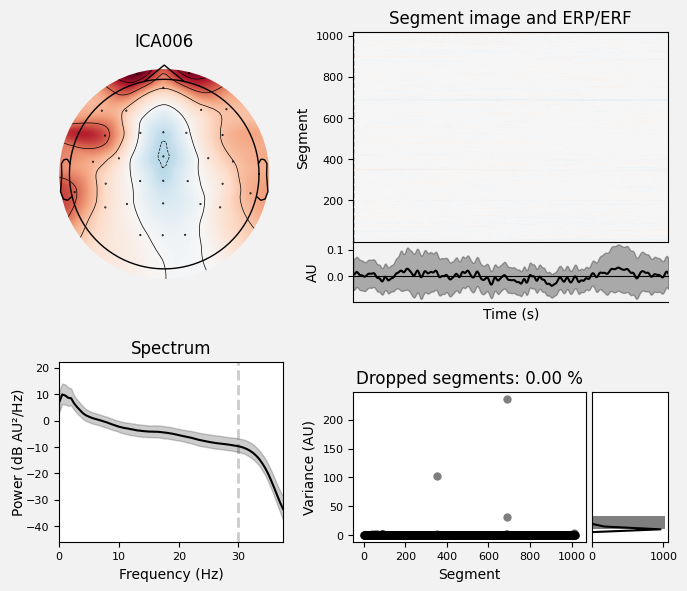

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


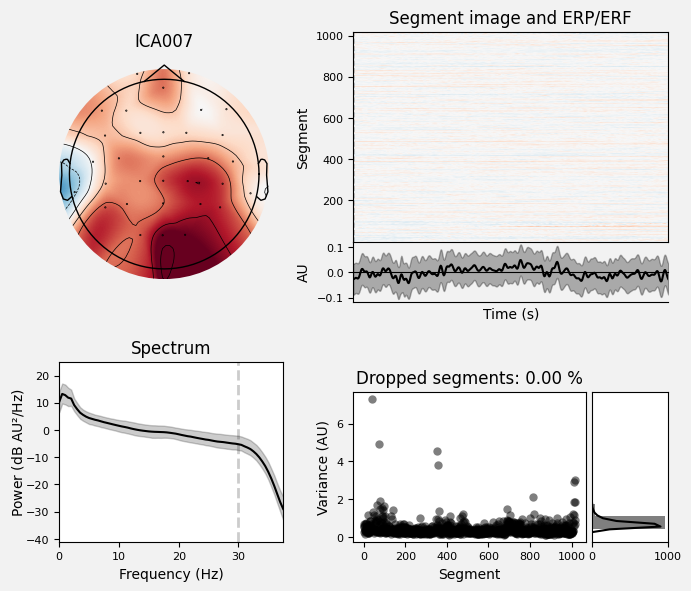

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


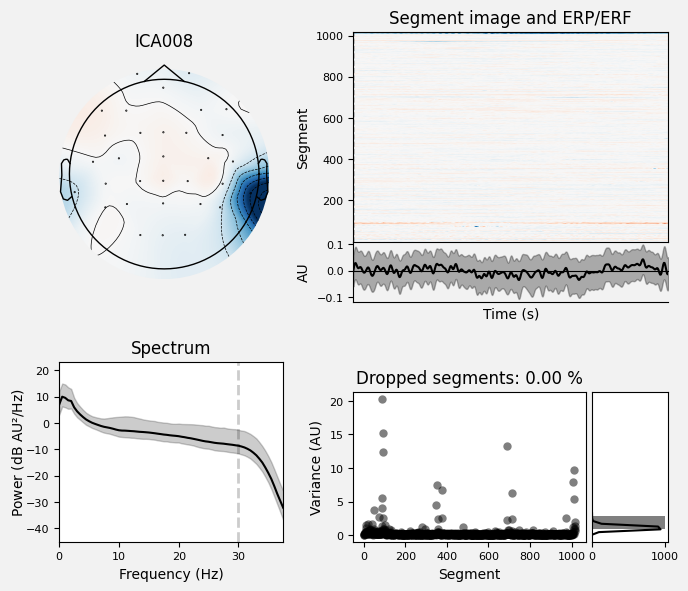

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


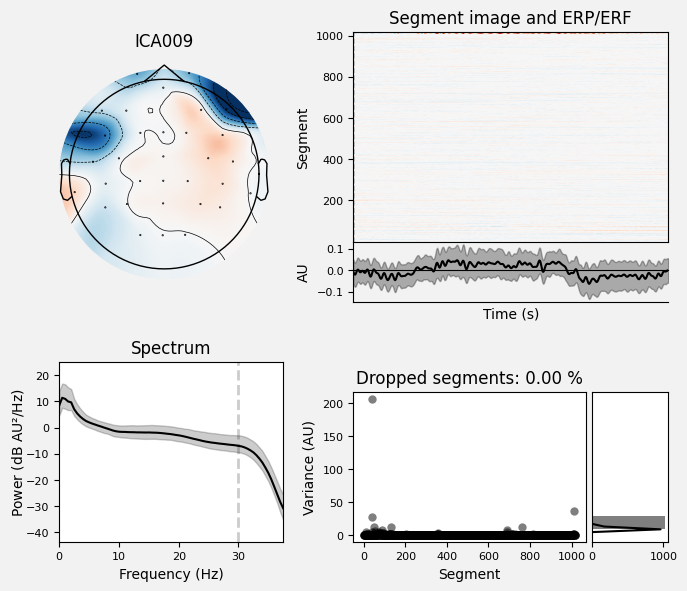

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1018 matching events found
No baseline correction applied
0 projection items activated


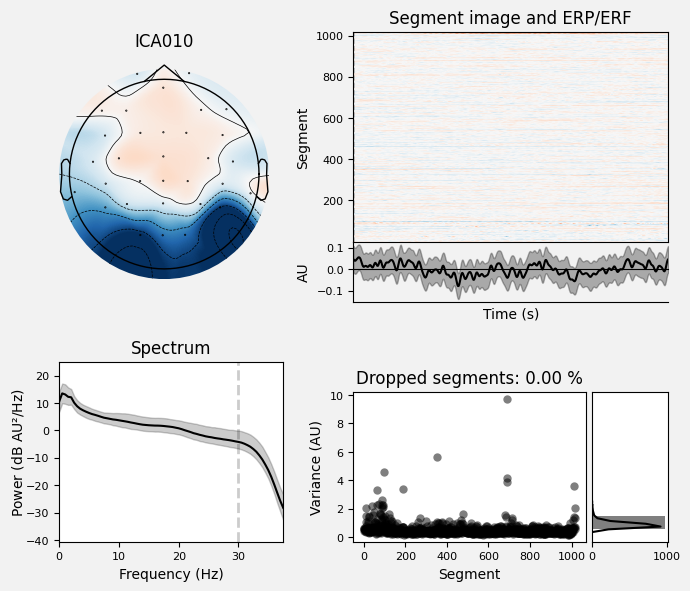

[<Figure size 700x600 with 6 Axes>]

In [19]:
ica.plot_properties(raw, picks=0)
ica.plot_properties(raw, picks=1)
ica.plot_properties(raw, picks=2)
ica.plot_properties(raw, picks=3)
ica.plot_properties(raw, picks=4)
ica.plot_properties(raw, picks=5)
ica.plot_properties(raw, picks=6)
ica.plot_properties(raw, picks=7)
ica.plot_properties(raw, picks=8)
ica.plot_properties(raw, picks=9)
ica.plot_properties(raw, picks=10)

### Excluding Artifact ICA Components
Thanks to the ICLabel tutorial on telling components apart (SCCN: Independent Component Labeling. (n.d.). https://labeling.ucsd.edu/tutorial/labels), I was able to interpret the ICA components with greater confidence. Through visual inspection, I identified the following:

Eyeblink and eye movement components:

- ICA0, ICA2, ICA3, and ICA4

- These showed typical frontopolar topographies, sharp time-domain features, and low-frequency dominance — characteristic of ocular artifacts.

Other movement artifact:

- ICA5

- This component didn't match the ocular profiles but exhibited non-neural patterns suggestive of head or muscle movement.

This step allowed for a manual confirmation and refinement of what automated tools missed. It also built on my growing ability to classify ICA components based on shape, topography, and spectral patterns.

In [20]:
ica.exclude = [0, 2, 3, 4, 5]
raw_clean02345 = raw.copy()
ica.apply(raw_clean02345)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


<RawEEGLAB | sub-02_task-songfamiliarity_eeg.fdt, 32 x 521357 (2036.6 s), ~127.3 MiB, data loaded>

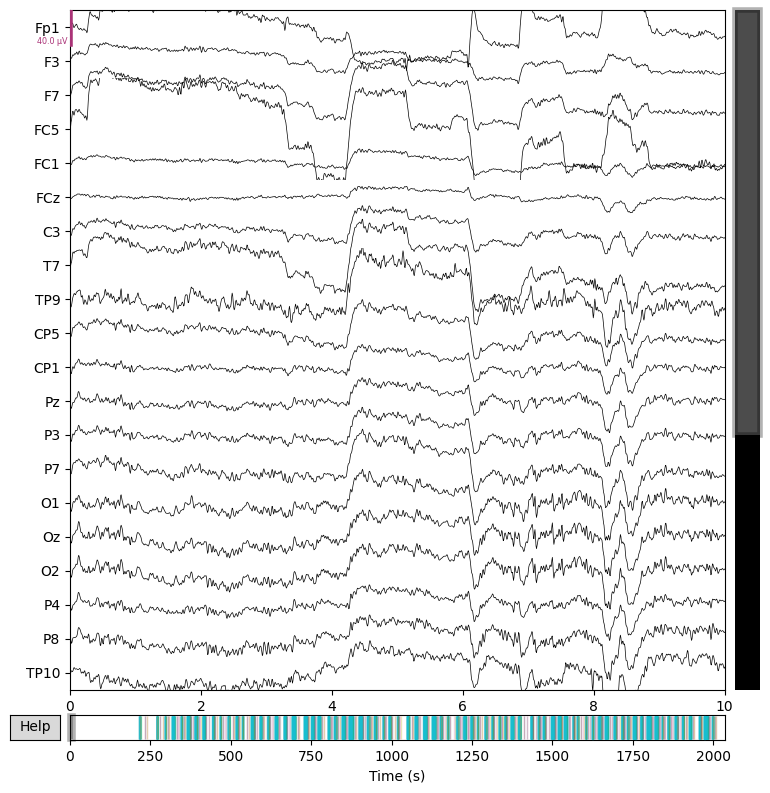

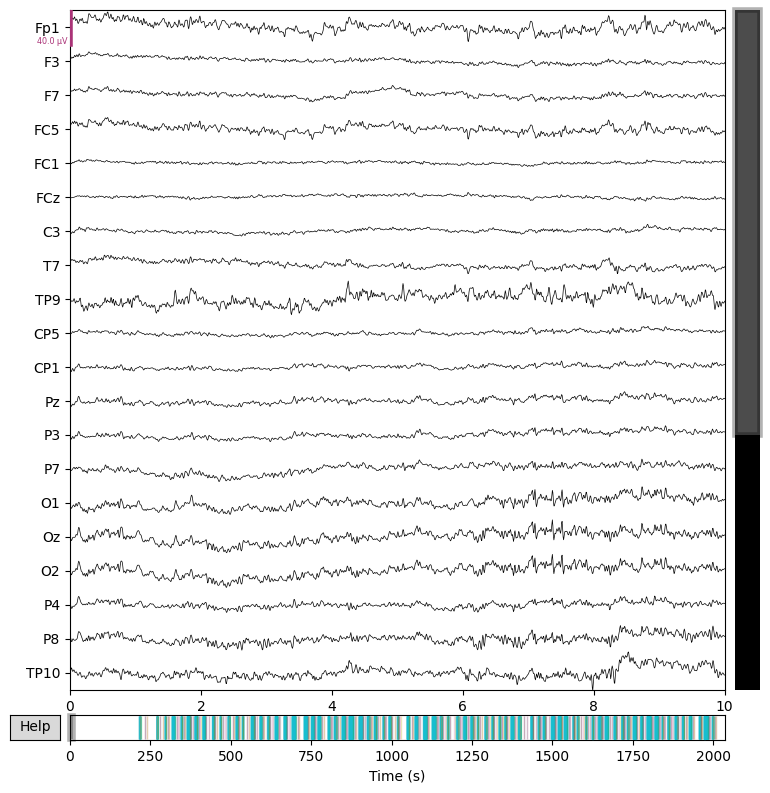

In [21]:
plot_raw = raw.plot()
plot_raw_clean02345 = raw_clean02345.plot()

## Step 5 - Event Selection, Epoch Creation and Further Cleaning

### Epoch Creation
With the artifact-cleaned EEG data (raw_clean02345) and the previously labeled events, I defined a custom event_id dictionary to select the events of interest.This includes both raw event markers and custom relabeled events derived from my label_note_epochs_full() function, which identified note onsets and mapped them based on the next multiple-choice outcome (correct/incorrect).

I then created epochs ranging from −200 ms to +800 ms around the event markers.
- Baseline correction was disabled (baseline=None) at this stage to allow inspection of raw trends before applying any additional correction.

- event_repeated='merge' ensures repeated events at the same sample are handled appropriately (merged, not dropped).

In [22]:
event_ids = {
    "response (spacebar)": 2,
    "onset MC": 5,
    "MC response": 6,
    "onset MC (correct)": 7,
    "onset MC (incorrect)": 8,
    "note onset (familiar)": 100,
    "note onset (unfamiliar)": 101
}
epochs = mne.Epochs(raw_clean02345, labeled_events, event_id=event_ids,tmin=-0.2,tmax=0.8, baseline=None, preload=True,event_repeated='merge')

print(f"Epochs created: {len(epochs)}")
print(epochs.drop_log_stats())

Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
1753 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1753 events and 257 original time points ...
0 bad epochs dropped
Epochs created: 1753
45.79468150896722


### AutoRejection

To ensure that only high-quality trials contribute to ERP analysis, I used the AutoReject package to automatically identify and reject noisy epochs.

What AutoReject Does:
- Learns optimal peak-to-peak thresholds per channel via cross-validation.

- Interpolates bad sensors within good epochs where possible.

- Rejects entire epochs when signal quality is too poor.

This step helps to:

- Improve signal-to-noise ratio.

- Reduce bias from manual rejection.

- Retain more usable data compared to conservative hard thresholds.


[Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.](https://hal.science/hal-01313458/document)

[Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.](https://doi.org/10.1016/j.neuroimage.2017.06.030)

In [23]:
ar = AutoReject()  # You can add parameters later if needed
epochs_cleaned, reject_log = ar.fit_transform(epochs, return_log=True)

c:\Users\anouk\OneDrive\Coding projects\Song familiarity\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 32/32 [00:02<00:00,   11.14it/s]
100%|██████████| Computing thresholds ... : 32/32 [02:57<00:00,    5.55s/it]



















































































































































































































































































































































































































































































































































































































































































































































































































































































Estimated consensus=0.90 and n_interpolate=4


Dropped 11 epochs: 410, 411, 412, 413, 414, 415, 1074, 1075, 1076, 1077, 1078


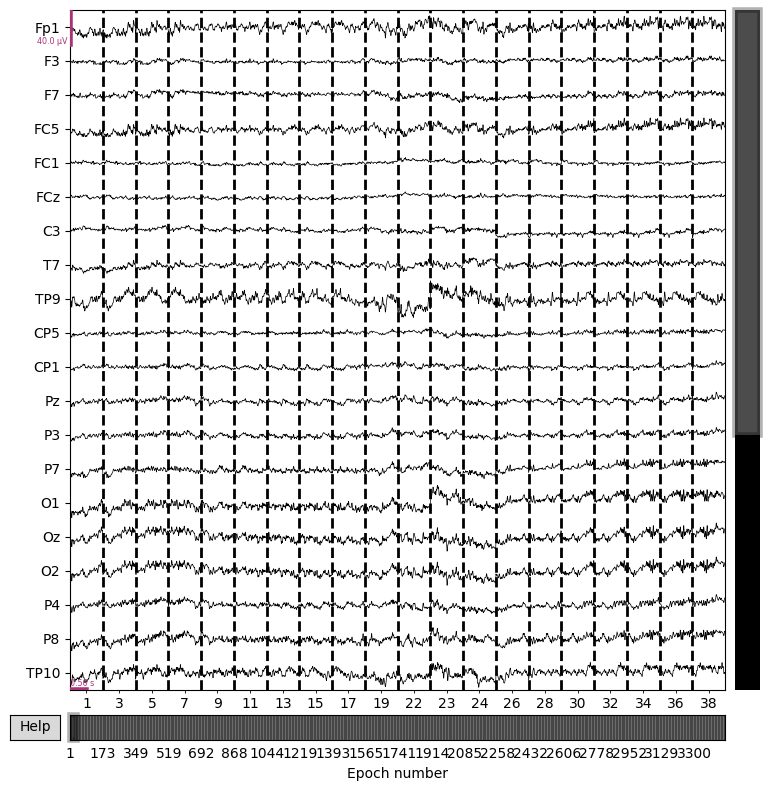

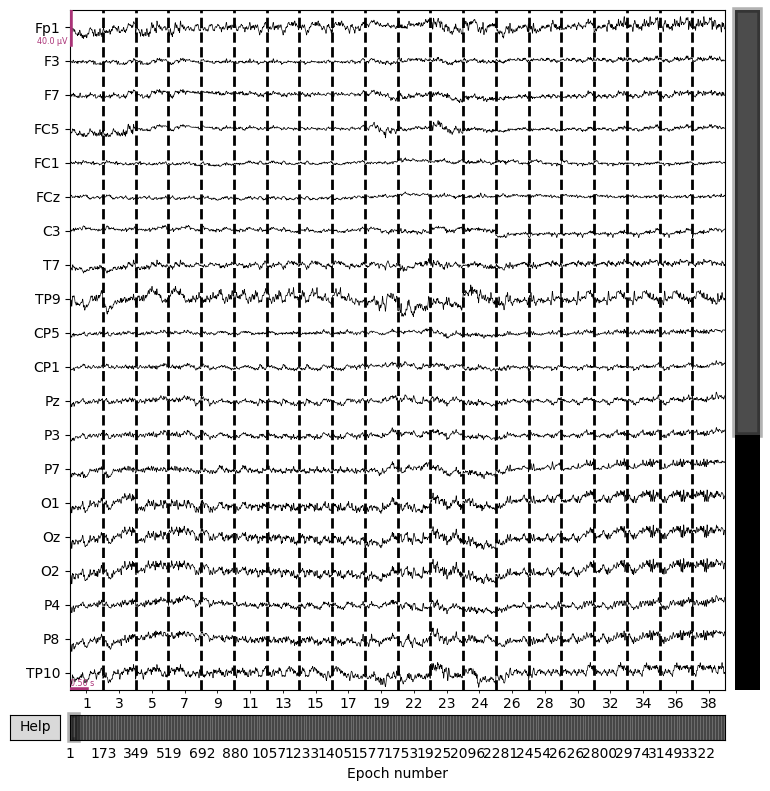

In [24]:
epochs_plot = epochs.plot()
epochs_clean_plot = epochs_cleaned.plot()

## Step 6 - Re-referencing EEG Signals

To prepare the data for ERP analysis, I re-referenced the EEG signals to the average of all electrodes using an MNE projection.

Why Re-reference?
- EEG is a differential signal, so choosing a reference affects all downstream analyses.

- Using the average reference is a common and neutral choice, especially with dense or evenly spaced montages (like our 32-channel standard_1020 layout).

- Applying it as a projection ensures it’s incorporated into forward/inverse modeling and can be toggled or removed later.

This step ensures consistency across trials and reduces potential bias from a poor initial reference.

In [25]:
epochs_cleaned.set_eeg_reference('average', projection=True) 

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<Epochs | 1742 events (all good), -0.199 – 0.801 s (baseline off), ~109.3 MiB, data loaded,
 'response (spacebar)': 47
 'onset MC': 75
 'MC response': 75
 'onset MC (correct)': 35
 'onset MC (incorrect)': 40
 'note onset (familiar)': 744
 'note onset (unfamiliar)': 726>

## Step 7 - Baseline Correction

To correct for pre-stimulus voltage shifts, I applied baseline correction using the pre-stimulus interval.

What does this do?
- Subtracts the mean voltage in the interval before stimulus onset (t < 0) from the entire epoch.

- Helps remove slow drifts and align all epochs to a common starting point.

- In this case, the baseline includes all data before time 0, up to the start of the event.

In [26]:
epochs_cleaned.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<Epochs | 1742 events (all good), -0.199 – 0.801 s (baseline -0.199 – 0 s), ~109.3 MiB, data loaded,
 'response (spacebar)': 47
 'onset MC': 75
 'MC response': 75
 'onset MC (correct)': 35
 'onset MC (incorrect)': 40
 'note onset (familiar)': 744
 'note onset (unfamiliar)': 726>

## Step 8 - Visual Inspection of Averaged Epochs
Now that the data is cleaned and baseline-corrected, I examined the average brain responses to familiar and unfamiliar notes.

- These maps provide a quick visual check to see if the data makes sense and is clean enough for further analysis.

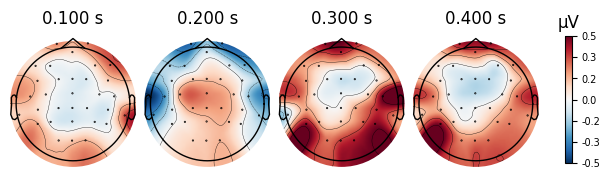

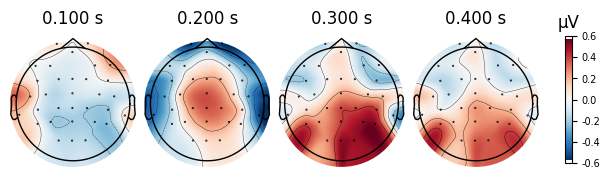

In [27]:
# Access separate conditions
epochs_familiar = epochs_cleaned['note onset (familiar)'].average()
epochs_unfamiliar = epochs_cleaned['note onset (unfamiliar)'].average()

times = [0.1, 0.2, 0.3, 0.4]  # timepoints in seconds after stimulus
topo_fam = epochs_familiar.plot_topomap(times=times)
topo_unfam = epochs_unfamiliar.plot_topomap(times=times)

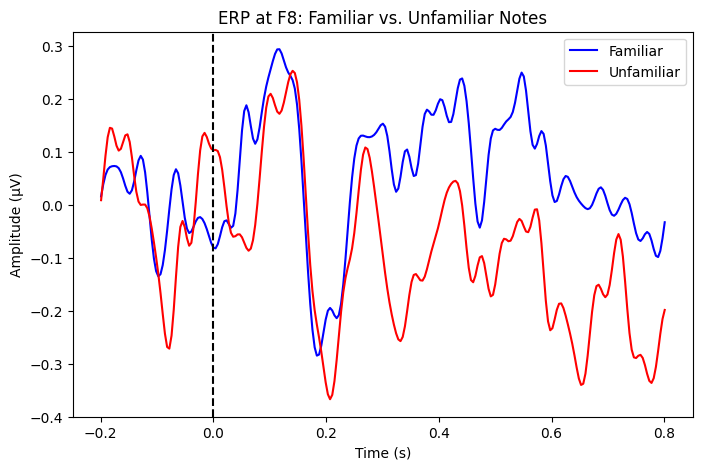

In [28]:
# Choose a representative channel or pick the grand average across all EEG channels
channel = 'F8'  


# Plot ERP of both conditions at the chosen channel
plt.figure(figsize=(8, 5))
plt.plot(epochs_familiar.times, epochs_familiar.data[epochs_familiar.ch_names.index(channel)] * 1e6, label='Familiar', color='blue')
plt.plot(epochs_unfamiliar.times, epochs_unfamiliar.data[epochs_unfamiliar.ch_names.index(channel)] * 1e6, label='Unfamiliar', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'ERP at {channel}: Familiar vs. Unfamiliar Notes')
plt.legend()
plt.axvline(0, color='k', linestyle='--', label='Stimulus onset')
plt.show()

## ERP Components: PReliminary Observations

At this stage, we cannot yet make definitive claims about specific ERP components, as the analysis is currently limited to a single participant. To draw more robust conclusions, I plan to combine data from multiple participants and compute grand-averaged ERPs. This will provide a clearer and more reliable picture of the neural responses.

That said, based on the task design and previous literature (Jagiello et al., 2019), we expected to observe some differentiation between familiar and unfamiliar note presentations. Specifically, we anticipated potential differences in the right frontotemporal region between 350 ms and 750 ms post-stimulus, possibly reflecting recognition-related components.

Future group-level analysis will be essential to confirm whether such effects are consistent across participants and statistically meaningful.


Jagiello, R., Pomper, U., Yoneya, M., Zhao, S., & Chait, M. (2019). Rapid Brain Responses to Familiar vs. Unfamiliar Music – an EEG and Pupillometry study. Scientific Reports, 9(1). https://doi.org/10.1038/s41598-019-51759-9

In [30]:
epochs_cleaned.save("C:/Users/anouk/OneDrive/Coding projects/Song familiarity/preprocessed"+"\\sub-002_epochs_preprocessed", overwrite=True)

Overwriting existing file.


C:\Users\anouk\AppData\Local\Temp\ipykernel_11388\225379212.py:1: RuntimeWarning: This filename (C:/Users/anouk/OneDrive/Coding projects/Song familiarity/preprocessed\sub-002_epochs_preprocessed) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_cleaned.save("C:/Users/anouk/OneDrive/Coding projects/Song familiarity/preprocessed"+"\\sub-002_epochs_preprocessed", overwrite=True)


Overwriting existing file.


[WindowsPath('C:/Users/anouk/OneDrive/Coding projects/Song familiarity/preprocessed/sub-002_epochs_preprocessed')]